## 1. Objective
The objective of this project is to develop a predictive model to identify the likelihood of loan defaults using a diverse set of borrower and loan characteristics. By analyzing and preprocessing key features such as borrower demographics, loan details, and credit history, this model aims to provide actionable insights that can help financial institutions mitigate risk, optimize lending strategies, and improve decision-making in credit management.

### 2. Exploration of Data

### 2.1 Snapshot of Loan Data
Data consists of static traits from loans with each row representing one loan. 

In [1]:
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pprint as p
import warnings
import matplotlib.pyplot as plt
import altair as alt 
import warnings
import shap
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

def remove_outliers(data, target):
    Q1 = data[target].quantile(0.25)
    Q3 = data[target].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[target] >= lower_bound) & (data[target] <= upper_bound)]

def create_hist(data, title, ax=None, xlim=False,bins=30, color=None):  
    if ax is None:
        plt.figure(figsize=(5, 3))
        sns.histplot(data, bins=bins, kde=False, color=color)

        plt.title(title)
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(False)
        plt.xticks(rotation=45)
        if xlim:
            plt.xlim(data.min(), (data.max() / 2))
        plt.show()
    else:
        sns.histplot(data, bins=30, kde=False, ax=ax, color=color)
        ax.set_title(title)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.grid(False)
        ax.tick_params(axis='x', rotation=45)
        if xlim:
            ax.set_xlim(data.min(), data.max() / 2)

raw_data = pd.read_csv('data/credit_risk_dataset.csv')
data = raw_data.copy()
raw_data['loan_status_mapped'] = raw_data['loan_status'].map({1: '1: Default', 0: '0: Fully Paid'})
alt.data_transformers.disable_max_rows()
raw_data['person_age'] = raw_data[raw_data['person_age'] <= 80]['person_age']

def chart_distribution(data, target):
    chart = alt.Chart(data).mark_bar().encode(
        alt.X(f'{target}:Q'),
        y='count():Q',
        color='loan_status_mapped:O',
        tooltip=[target, 'count()', 'loan_status'],
    ).properties(
        width=600,
        height=400,
        title=f'Distribution of {target}'
    )
    return chart

non_scaled = pd.read_csv('data/non_scaled.csv')
display(non_scaled.head())

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,DTI
0,22,59000,2.0,123.0,3.0,35000,16.02,1,0.59,1,3,False,False,False,True,False,0.593220
1,21,9600,0.0,5.0,1.0,1000,11.14,0,0.10,0,2,True,False,False,False,False,0.104167
2,25,9600,1.0,1.0,2.0,5500,12.87,1,0.57,0,3,False,False,True,False,False,0.572917
3,23,65500,2.0,4.0,2.0,35000,15.23,1,0.53,0,2,False,False,True,False,False,0.534351
4,24,54400,2.0,8.0,2.0,35000,14.27,1,0.55,1,4,False,False,True,False,False,0.643382


There are a total of 32581 rows in the dataset and there are 17 variables.

The target variable is loan_status and it represents whether or not the loan was paid back. The values are [1 0] with 0 representing a loan that was paid back and 1 representing a loan that was not paid back.

### 2.2 Distribution of Target Variable

In [2]:
target_dist = alt.Chart(raw_data).mark_bar().encode(
    alt.X('loan_status_mapped:O'),
    y='count()',
    tooltip=['loan_status_mapped', 'count()'],
    color='loan_status_mapped'
).properties(
    width=300,
    height=200,
    title='Distribution of Loan Status'
)
target_dist.save('charts/Target_Distribution.png')


The target variable is pretty unbalanced with majority of loans not defaulting. There are about 25,473 loans that did not have any problems being payed back or about 78%. While 7,108 loans did default or about 21%.

### 2.3 Distribution of Age

In [3]:
age_dist = chart_distribution(raw_data, 'person_age') 
age_dist.save('charts/Age_Distribution.png')

There is a notable concentration of borrowers between the ages of 20 and 25 who have taken out loans. Interestingly, the age distribution of loans that have been successfully paid off closely mirrors the overall age distribution within the entire dataset. However, the highest incidence of loan defaults is observed among 22-year-olds, while borrowers over the age of 34 have very few recorded defaults. This pattern suggests varying levels of financial risk and repayment behavior across different age groups.

### 2.4 Home Ownership Distribution

In [4]:

Home_Ownership_dist = alt.Chart(raw_data).mark_bar().encode(
    alt.X('person_home_ownership:O'),
    y='count()',
    color='loan_status_mapped:O',
    tooltip=['person_home_ownership', 'count()', 'loan_status_mapped'],
).properties(
        width=600,
        height=400,
        title=f'Distribution of Home Ownership'
    )
Home_Ownership_dist.save('charts/Home_Ownership_Distribution.png')

The distribution of home ownership reveals that the majority of loans are granted to individuals who are renting(~16k), with the smallest number of loans going to those who own their homes outright(~2k). Interestingly, the highest proportion of paid-off loans belongs to individuals with mortgages(~12k). However, this might be misleading, as those who already own their homes are mostly free of loan obligations(<500). Renters, on the other hand, account for the highest number of loan defaults(~6k). This suggest that renters  have most dificulty paying back loans.

### 2.5 Distribution of Income

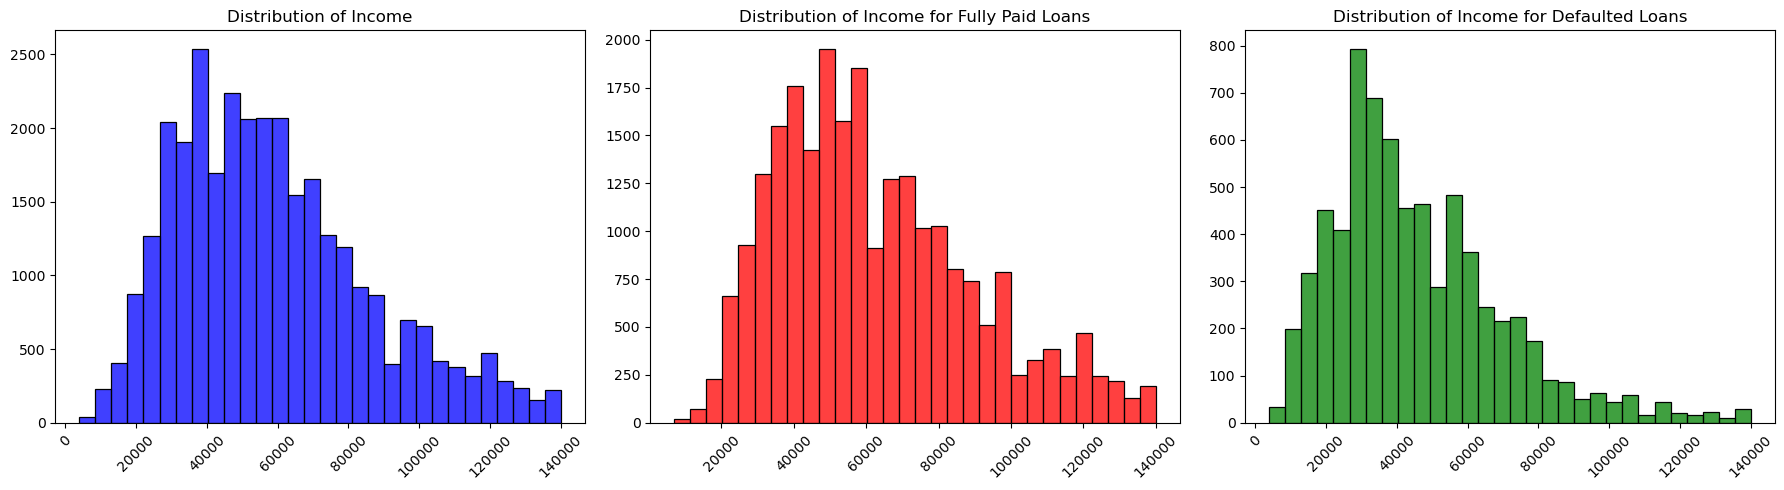

In [5]:

filtered_df = remove_outliers(raw_data, 'person_income')
_, axes = plt.subplots(1,3, figsize=(18, 5))
create_hist(filtered_df['person_income'], 'Distribution of Income',ax=axes[0], color='blue')
income_1 = filtered_df[filtered_df['loan_status'] == 1]['person_income']
income_0 = filtered_df[filtered_df['loan_status'] == 0]['person_income']
create_hist(income_0, 'Distribution of Income for Fully Paid Loans',ax=axes[1], color='red')
create_hist(income_1, 'Distribution of Income for Defaulted Loans',ax=axes[2], color='green')
plt.tight_layout()
plt.show()





The distribution of income reveals that the majority of loans are granted to individuals who make between 40k and 60k, with an intresting outlier at 120k with a large spike. If you notice on the Y axis this dataset had to be filtered down to excude outlier with very few high income individuals having a large inpact on the distribution. The distribution amongst all those who recieve lons and those who do or dont default is very similair leading to income alone not being the **cause** of default.

### 2.6 Distribution of Loan Amounts

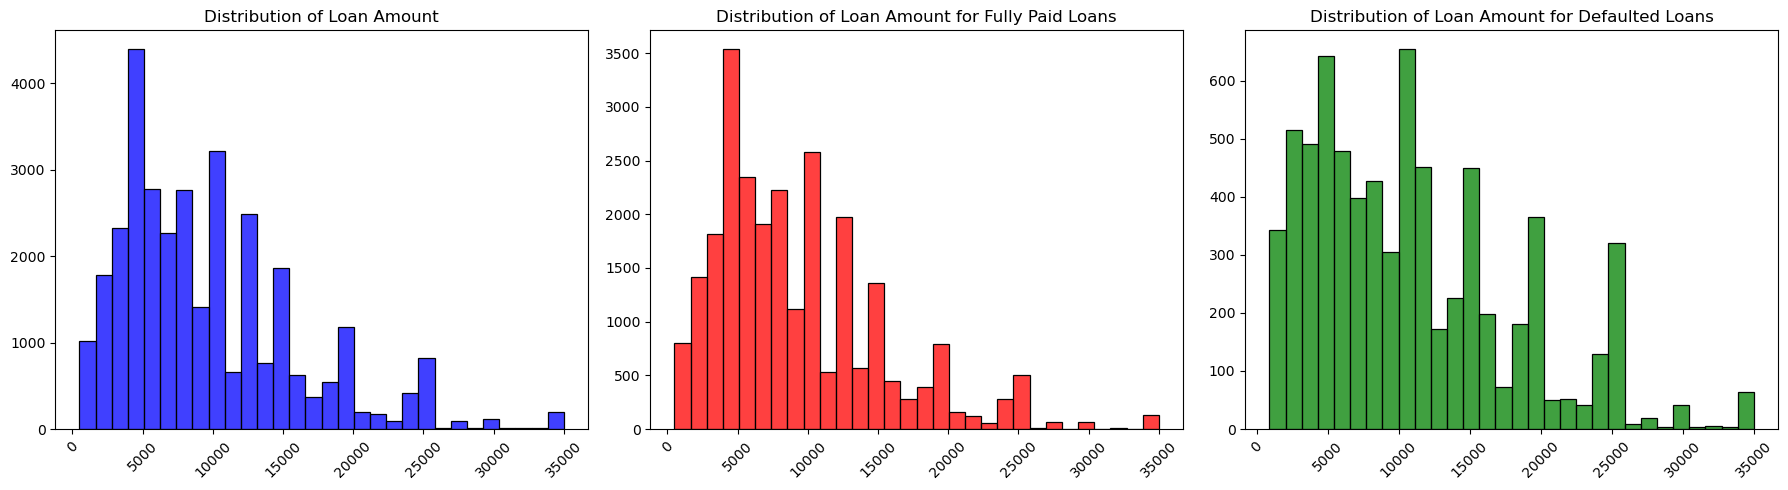

In [6]:
_, axes = plt.subplots(1,3, figsize=(18, 5))
create_hist(raw_data['loan_amnt'], 'Distribution of Loan Amount', ax=axes[0], color='blue')
loan_amnt_1 = raw_data[raw_data['loan_status'] == 1]['loan_amnt']
loan_amnt_0 = raw_data[raw_data['loan_status'] == 0]['loan_amnt']
create_hist(loan_amnt_0, 'Distribution of Loan Amount for Fully Paid Loans',ax=axes[1], color='red')
create_hist(loan_amnt_1, 'Distribution of Loan Amount for Defaulted Loans',ax=axes[2], color='green')
plt.tight_layout()
plt.show()

The distribution of the loan amounts shows that majority of loans are for just over five thousand(~4k people), with a spike around 10k, 15k, 20k and 25k. Those loan amounts also had the most defaults even when accounting for thier higher presence to begin with. This shows bias towards loans with these round numbers but also shows that highers loans may lead to a higher defualt rate.

### 2.7 Distribution of Loan interest Rate

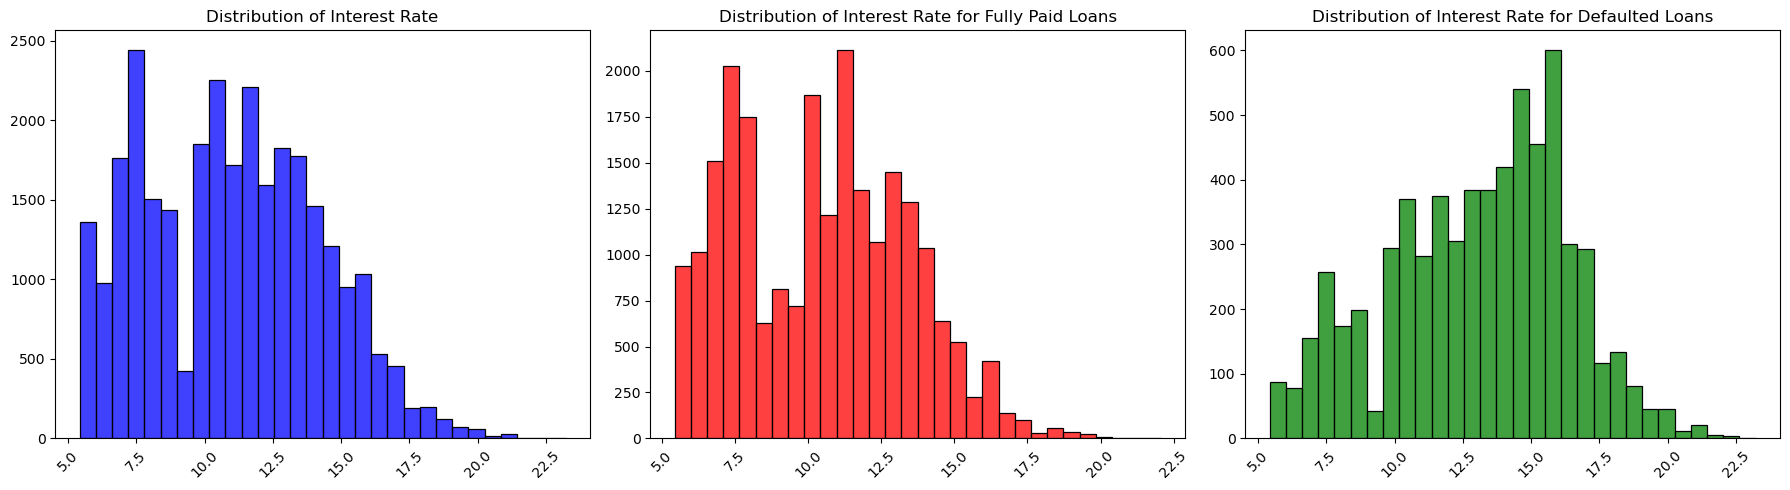

In [7]:
_, axes = plt.subplots(1,3, figsize=(18, 5))
create_hist(raw_data['loan_int_rate'], 'Distribution of Interest Rate', ax=axes[0], color='blue')
loan_int_rate_1 = raw_data[raw_data['loan_status'] == 1]['loan_int_rate']
loan_int_rate_0 = raw_data[raw_data['loan_status'] == 0]['loan_int_rate']
create_hist(loan_int_rate_0, 'Distribution of Interest Rate for Fully Paid Loans',ax=axes[1], color='red')
create_hist(loan_int_rate_1, 'Distribution of Interest Rate for Defaulted Loans',ax=axes[2], color='green')
plt.tight_layout()
plt.show()

There is an interestingly high number of loans with an interest rate of 7.5% (approximately 2.4k loans), while the mean interest rate is around 11%. Interestingly, there is a very high correlation between interest rates and loan defaults, with the distribution being negatively skewed. This leads me to believe that loans with a high interest rate are more likely to default.

### 2.8 Distribution of Loan Percent Income

In [8]:
loan_percent_income_dist = chart_distribution(raw_data, 'loan_percent_income')
loan_percent_income_dist.save('charts/Loan_Percent_Income_Distribution.png')


The distribution of the loan percent of income is primarily concentrated between 1% and 2%, with a noticeable spike around 4%. Loans exceeding this 4% threshold show a higher likelihood of default, as a greater proportion of these loans end up in default compared to those successfully repaid. This suggests that borrowers with higher loan-to-income ratios face increased financial strain, leading to a higher risk of default.

### 2.9 Distribution of Loan Grade

In [9]:
loan_grade_dist = alt.Chart(raw_data).mark_bar().encode(
    alt.X('loan_grade:O'),
    y='count()',
    color='loan_status_mapped:O',
    tooltip=['loan_grade', 'count()', 'loan_status_mapped'],
).properties(
        width=600,
        height=400,
        title=f'Distribution of Loan Grade'
)
loan_grade_dist.save('charts/Loan_Grade_Distribution.png')

The distribution indicates that the majority of loans are Grade A, with most of these being successfully repaid. In contrast, loans classified as Grade D and below have a significantly higher default rate, with nearly half of them resulting in default. This trend suggests a clear correlation between lower loan grades and an increased risk of default.
### 2.10 Distribution of Previous Defualt

In [10]:
prev_default = alt.Chart(raw_data).mark_bar().encode(
    alt.X('cb_person_default_on_file:O'),
    y='count()',
    color='loan_status_mapped:O',
    tooltip=['cb_person_default_on_file', 'count()', 'loan_status_mapped'],
).properties(
        width=600,
        height=400,
        title=f'Distribution of Previous Defaults'
    )
prev_default.save('charts/Previous_Defaults_Distribution.png')

The majority of borrowers do not have a previous default on file. However, among those who do, nearly half default again, indicating a high risk of repeated default. In contrast, about 1 in 5 borrowers without a prior default end up defaulting on their current loan, highlighting a lower but still notable risk.

## 3. Baseline Model
### 3.1 Dataset Preparation

In [11]:
data = pd.read_csv('data/credit_risk_dataset.csv')

# Ordinal Encoding
loan_grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
home_ownership_order = ['OWN', 'MORTGAGE', 'RENT', 'OTHER']

loan_grade_encoder = OrdinalEncoder(
    categories=[loan_grade_order], dtype=float)
home_ownership_encoder = OrdinalEncoder(
    categories=[home_ownership_order], dtype=float)

data['loan_grade'] = loan_grade_encoder.fit_transform(
    data.loan_grade.values.reshape(-1, 1))
data['person_home_ownership'] = home_ownership_encoder.fit_transform(
    data.person_home_ownership.values.reshape(-1, 1))

# One-Hot Encoding
if 'loan_intent' in data.columns:
    data = pd.get_dummies(data, columns=['loan_intent'], drop_first=True)
data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map({'Y': 1, 'N': 0})




### 3.2 Feature Engineering

In [12]:
data['DTI'] = data['loan_amnt'] / data['person_income']
data.to_csv('data/non_scaled.csv', index=False)

### 3.3 Feature Scaling

In [13]:

numeric_features = ['person_age', 'person_income', 'person_emp_length',
                    'loan_amnt', 'loan_percent_income', 'cb_person_cred_hist_length', 'DTI']

standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

data[numeric_features] = standard_scaler.fit_transform(
    data[numeric_features])
data['loan_int_rate'] = robust_scaler.fit_transform(
    data['loan_int_rate'].values.reshape(-1, 1))

data = data.astype(float).dropna()


### 3.4 Create Validation Sets

In [14]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv('data/train.csv', index=False)
test_df.to_csv('data/test.csv', index=False)

### 3.5 Model Selection

In [15]:
# List of models to test
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    'LightGBM': LGBMClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42, verbose=0),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Stacking': StackingClassifier(
        estimators=[
            ('cat', CatBoostClassifier(random_state=42, verbose=0)),
            ('lbg', LGBMClassifier(random_state=42, verbose=0)),
            ('xgb', XGBClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression()
    )
}

best_model_name = None
best_weighted_avg_f1 = 0

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    weighted_avg_f1 = report['weighted avg']['f1-score']
    print(f"Model: {model_name}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("\n")
    
    if weighted_avg_f1 > best_weighted_avg_f1:
        best_weighted_avg_f1 = weighted_avg_f1
        best_model_name = model_name

print(f"Best Model: {best_model_name} with Weighted Avg F1-Score: {best_weighted_avg_f1}")

Model: Logistic Regression
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81      4443
         1.0       0.81      0.80      0.81      4443

    accuracy                           0.81      8886
   macro avg       0.81      0.81      0.81      8886
weighted avg       0.81      0.81      0.81      8886



Model: Decision Tree
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      4443
         1.0       0.91      0.87      0.89      4443

    accuracy                           0.89      8886
   macro avg       0.89      0.89      0.89      8886
weighted avg       0.89      0.89      0.89      8886



Model: Random Forest
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92      4443
         1.0       0.99      0.84      0.91      4443

    accuracy                           0.92      8886
   macro avg       0.93      0.92      0.92      8886
w

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: Neural Network
              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88      4443
         1.0       0.91      0.82      0.87      4443

    accuracy                           0.87      8886
   macro avg       0.88      0.87      0.87      8886
weighted avg       0.88      0.87      0.87      8886



Model: XGBoost
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      4443
         1.0       0.99      0.92      0.95      4443

    accuracy                           0.95      8886
   macro avg       0.96      0.95      0.95      8886
weighted avg       0.96      0.95      0.95      8886



Model: CatBoost
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      4443
         1.0       0.99      0.92      0.96      4443

    accuracy                           0.96      8886
   macro avg       0.96      0.96      0.96      8886
weighted avg     

/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoost
              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      4443
         1.0       0.89      0.86      0.88      4443

    accuracy                           0.88      8886
   macro avg       0.88      0.88      0.88      8886
weighted avg       0.88      0.88      0.88      8886



Model: Stacking
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      4443
         1.0       0.99      0.93      0.96      4443

    accuracy                           0.96      8886
   macro avg       0.96      0.96      0.96      8886
weighted avg       0.96      0.96      0.96      8886



Best Model: Stacking with Weighted Avg F1-Score: 0.9588881367901392


## 4. Model Finalization and Visualization
### 4.1 Retrain and Optimize best model

In [18]:
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Define the base estimators
estimators = [
    ('cat', CatBoostClassifier(random_state=42, verbose=0)),
    ('lbg', LGBMClassifier(random_state=42)),
    ('xgb', XGBClassifier(random_state=42))
]

# Define the neural network model
def create_nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=len(estimators), activation='relu')) #input length is the number of estimators
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) #output layer 1 neuron for binary classification
    # Compile the model with binary crossentropy loss function and adam optimizer 
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom Keras Classifier
class CustomKerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=10, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def predict_proba(self, X):
        return self.model.predict(X)

# Wrap the Keras model for use in scikit-learn
nn_model = CustomKerasClassifier(build_fn=create_nn_model, epochs=300, batch_size=32, verbose=0)

# Define the stacking model
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=nn_model
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)

stacking_model.fit(X_train, y_train)

y_pred = stacking_model.predict(X_test)

print(classification_report(y_test, y_pred))


278/278 [==============================] - 0s 244us/step
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      4443
         1.0       0.99      0.92      0.96      4443

    accuracy                           0.96      8886
   macro avg       0.96      0.96      0.96      8886
weighted avg       0.96      0.96      0.96      8886



/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


After evaluating 12 different models, the stacking model emerged as the best performer. This stacking model leverages the predictions of the top three models as base estimators and combines their outputs using a Logistic Regression model to predict loan defaults. The stacking model achieved an impressive average precision, recall, and F1-score of 94%.
### 4.2 Visualize Confusion Matrix

In [19]:
import joblib
joblib.dump(stacking_model, '/models/stacking_model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/models/stacking_model.pkl'

In [24]:
from sklearn.metrics import confusion_matrix
import altair as alt

matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(matrix,
                                columns=['Predicted Negative',
                                        'Predicted Positive'],
                                index=['Actual Negative', 'Actual Positive'])

# Melt the DataFrame to long format
conf_matrix_melted = conf_matrix_df.reset_index().melt(id_vars='index')
conf_matrix_melted.columns = ['Actual', 'Predicted', 'Count']

# Create the heatmap using Altair
heatmap = alt.Chart(conf_matrix_melted).mark_rect().encode(
    x='Predicted:O',
    y='Actual:O',
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Actual', 'Predicted', 'Count']
).properties(
    width=300,
    height=300,
    title='Confusion Matrix'
)

# Add text annotations
text = heatmap.mark_text(baseline='middle').encode(
    text='Count:Q',
    color=alt.condition(
        alt.datum.Count > conf_matrix_melted['Count'].mean(),
        alt.value('black'),
        alt.value('white')
    )
)

# Combine heatmap and text

conf_matrix_chart = heatmap + text

# Display the chart
conf_matrix_chart.display()
conf_matrix_chart.save('charts/confusion_matrix.html')

AttributeError: 'Adam' object has no attribute 'build'

This visualization of the confusion matrix shows that the model predicted that 4,443 loans would not default and it was correct about 4,392 of them getting 29 incorrect. 4,543 loans were predicted to defualt and 343 did not default. This shows the model is more likely to predict false negatives which if implemeted could lead to loans getting accepted that will default.

### 4.3 Visualize Feature Importance


In [ ]:
import numpy as np

model = stacking_model
# Aggregate feature importances from base estimators
importances = np.zeros(X.shape[1])
for name, estimator in model.named_estimators_.items():
    if hasattr(estimator, 'feature_importances_'):
        importances += estimator.feature_importances_
importances /= len(model.named_estimators_)

features = X.columns
importance_df = pd.DataFrame(
    {'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Create the bar chart
bar_chart = alt.Chart(importance_df.head(10)).mark_bar().encode(
    x=alt.X('Importance:Q', title='Importance'),
    y=alt.Y('Feature:O', sort='-x', title='Feature'),
    tooltip=['Feature', 'Importance'],
    color=alt.Color('Importance:Q', scale=alt.Scale(scheme='viridis'))
).properties(
    width=600,
    title='Top 10 Feature Importance'
)
bar_chart.save('charts/feature_importance.html')
bar_chart


alt.Chart(...)

4/4 [==============================] - 0s 1ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 264us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  1%|          | 1/100 [00:04<07:56,  4.81s/it]

1/1 [==============================] - 0s 19ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 298us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  2%|▏         | 2/100 [00:09<07:34,  4.64s/it]

1/1 [==============================] - 0s 13ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 297us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  3%|▎         | 3/100 [00:13<07:08,  4.42s/it]

1/1 [==============================] - 0s 17ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  4%|▍         | 4/100 [00:17<06:45,  4.22s/it]

1/1 [==============================] - 0s 20ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 288us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  5%|▌         | 5/100 [00:21<06:37,  4.18s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 297us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  6%|▌         | 6/100 [00:25<06:30,  4.16s/it]

1/1 [==============================] - 0s 30ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  7%|▋         | 7/100 [00:29<06:19,  4.08s/it]

1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 275us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  8%|▊         | 8/100 [00:33<06:12,  4.05s/it]

1/1 [==============================] - 0s 30ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
  9%|▉         | 9/100 [00:37<06:14,  4.11s/it]/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


1/1 [==============================] - 0s 26ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 310us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 10%|█         | 10/100 [00:42<06:28,  4.32s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 324us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 11%|█         | 11/100 [00:46<06:26,  4.34s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 282us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 12%|█▏        | 12/100 [00:50<06:13,  4.25s/it]

1/1 [==============================] - 0s 26ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 269us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 13%|█▎        | 13/100 [00:54<06:00,  4.15s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 14%|█▍        | 14/100 [00:58<05:51,  4.08s/it]

1/1 [==============================] - 0s 22ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 276us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 15%|█▌        | 15/100 [01:02<05:45,  4.06s/it]

1/1 [==============================] - 0s 38ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 279us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 16%|█▌        | 16/100 [01:06<05:41,  4.07s/it]

1/1 [==============================] - 0s 26ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 293us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 17%|█▋        | 17/100 [01:11<05:38,  4.08s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 274us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 18%|█▊        | 18/100 [01:14<05:31,  4.04s/it]

1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 284us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 19%|█▉        | 19/100 [01:19<05:27,  4.04s/it]

1/1 [==============================] - 0s 19ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 281us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 20%|██        | 20/100 [01:23<05:25,  4.07s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 294us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 21%|██        | 21/100 [01:27<05:22,  4.09s/it]

1/1 [==============================] - 0s 14ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 280us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 22%|██▏       | 22/100 [01:31<05:16,  4.06s/it]

1/1 [==============================] - 0s 22ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 280us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 23%|██▎       | 23/100 [01:35<05:10,  4.03s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 268us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 24%|██▍       | 24/100 [01:39<05:02,  3.98s/it]

1/1 [==============================] - 0s 20ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 274us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 25%|██▌       | 25/100 [01:43<04:56,  3.96s/it]

1/1 [==============================] - 0s 21ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 267us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 26%|██▌       | 26/100 [01:46<04:49,  3.91s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 268us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 27%|██▋       | 27/100 [01:50<04:45,  3.91s/it]

1/1 [==============================] - 0s 11ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 268us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 28%|██▊       | 28/100 [01:54<04:39,  3.88s/it]

1/1 [==============================] - 0s 28ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 268us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 29%|██▉       | 29/100 [01:58<04:34,  3.87s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 262us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 30%|███       | 30/100 [02:02<04:28,  3.83s/it]

1/1 [==============================] - 0s 14ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 315us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 31%|███       | 31/100 [02:06<04:32,  3.94s/it]

1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 299us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 32%|███▏      | 32/100 [02:10<04:37,  4.08s/it]/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


1/1 [==============================] - 0s 64ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 353us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 33%|███▎      | 33/100 [02:15<04:49,  4.32s/it]

1/1 [==============================] - 0s 13ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 313us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 34%|███▍      | 34/100 [02:19<04:46,  4.34s/it]

1/1 [==============================] - 0s 13ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 269us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 35%|███▌      | 35/100 [02:23<04:32,  4.19s/it]

1/1 [==============================] - 0s 11ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 267us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 36%|███▌      | 36/100 [02:27<04:22,  4.10s/it]

1/1 [==============================] - 0s 17ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 276us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 37%|███▋      | 37/100 [02:31<04:14,  4.04s/it]

1/1 [==============================] - 0s 11ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 289us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 38%|███▊      | 38/100 [02:35<04:11,  4.06s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 282us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 39%|███▉      | 39/100 [02:40<04:15,  4.18s/it]

1/1 [==============================] - 0s 51ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 340us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|████      | 40/100 [02:45<04:22,  4.37s/it]

1/1 [==============================] - 0s 34ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 335us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 41%|████      | 41/100 [02:49<04:19,  4.39s/it]

1/1 [==============================] - 0s 21ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 285us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 42%|████▏     | 42/100 [02:53<04:07,  4.27s/it]

1/1 [==============================] - 0s 35ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 274us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 43%|████▎     | 43/100 [02:57<03:58,  4.19s/it]

1/1 [==============================] - 0s 34ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 44%|████▍     | 44/100 [03:01<03:50,  4.11s/it]

1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 281us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 45%|████▌     | 45/100 [03:05<03:43,  4.06s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 275us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 46%|████▌     | 46/100 [03:09<03:37,  4.04s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 270us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 47%|████▋     | 47/100 [03:13<03:32,  4.01s/it]

1/1 [==============================] - 0s 30ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 48%|████▊     | 48/100 [03:17<03:27,  4.00s/it]

1/1 [==============================] - 0s 18ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 49%|████▉     | 49/100 [03:21<03:24,  4.01s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 50%|█████     | 50/100 [03:25<03:19,  3.98s/it]

1/1 [==============================] - 0s 28ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 51%|█████     | 51/100 [03:29<03:14,  3.96s/it]

1/1 [==============================] - 0s 38ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 52%|█████▏    | 52/100 [03:33<03:14,  4.06s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 53%|█████▎    | 53/100 [03:37<03:11,  4.06s/it]

1/1 [==============================] - 0s 17ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 327us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 54%|█████▍    | 54/100 [03:41<03:10,  4.15s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 264us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 55%|█████▌    | 55/100 [03:45<03:04,  4.09s/it]

1/1 [==============================] - 0s 20ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 56%|█████▌    | 56/100 [03:49<02:57,  4.04s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 57%|█████▋    | 57/100 [03:53<02:52,  4.01s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 285us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 58%|█████▊    | 58/100 [03:57<02:48,  4.01s/it]

1/1 [==============================] - 0s 29ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 284us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 59%|█████▉    | 59/100 [04:01<02:45,  4.04s/it]

1/1 [==============================] - 0s 28ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 60%|██████    | 60/100 [04:05<02:41,  4.03s/it]

1/1 [==============================] - 0s 22ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 268us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 61%|██████    | 61/100 [04:09<02:35,  3.99s/it]

1/1 [==============================] - 0s 14ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 255us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 62%|██████▏   | 62/100 [04:13<02:29,  3.94s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 268us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 63%|██████▎   | 63/100 [04:17<02:24,  3.91s/it]

1/1 [==============================] - 0s 19ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 64%|██████▍   | 64/100 [04:21<02:23,  3.97s/it]/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


1/1 [==============================] - 0s 46ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 342us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 65%|██████▌   | 65/100 [04:26<02:28,  4.25s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 331us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 66%|██████▌   | 66/100 [04:30<02:27,  4.33s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 280us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 67/100 [04:34<02:20,  4.24s/it]

1/1 [==============================] - 0s 24ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 275us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 68%|██████▊   | 68/100 [04:38<02:13,  4.17s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 278us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 69%|██████▉   | 69/100 [04:42<02:07,  4.12s/it]

1/1 [==============================] - 0s 22ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 70%|███████   | 70/100 [04:46<02:02,  4.09s/it]

1/1 [==============================] - 0s 35ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 281us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 71%|███████   | 71/100 [04:50<01:58,  4.08s/it]

1/1 [==============================] - 0s 23ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 283us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 72%|███████▏  | 72/100 [04:55<01:53,  4.07s/it]/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 73%|███████▎  | 73/100 [04:59<01:51,  4.13s/it]

1/1 [==============================] - 0s 21ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 74%|███████▍  | 74/100 [05:03<01:45,  4.07s/it]

1/1 [==============================] - 0s 28ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 75%|███████▌  | 75/100 [05:07<01:41,  4.04s/it]

1/1 [==============================] - 0s 20ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 76%|███████▌  | 76/100 [05:11<01:35,  4.00s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 271us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 77%|███████▋  | 77/100 [05:15<01:31,  3.99s/it]

1/1 [==============================] - 0s 27ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 291us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 78%|███████▊  | 78/100 [05:19<01:28,  4.04s/it]

1/1 [==============================] - 0s 19ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 275us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 79%|███████▉  | 79/100 [05:23<01:24,  4.02s/it]

1/1 [==============================] - 0s 18ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 279us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 80%|████████  | 80/100 [05:27<01:20,  4.03s/it]

1/1 [==============================] - 0s 22ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 81%|████████  | 81/100 [05:31<01:16,  4.02s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 82%|████████▏ | 82/100 [05:35<01:12,  4.01s/it]

1/1 [==============================] - 0s 25ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 83%|████████▎ | 83/100 [05:39<01:07,  3.99s/it]

1/1 [==============================] - 0s 13ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 84%|████████▍ | 84/100 [05:43<01:03,  3.99s/it]

1/1 [==============================] - 0s 18ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 285us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 85%|████████▌ | 85/100 [05:47<01:00,  4.02s/it]

1/1 [==============================] - 0s 27ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 86%|████████▌ | 86/100 [05:51<00:55,  3.99s/it]

1/1 [==============================] - 0s 34ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 274us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 87%|████████▋ | 87/100 [05:55<00:51,  4.00s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 88%|████████▊ | 88/100 [05:59<00:47,  3.98s/it]

1/1 [==============================] - 0s 19ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 89%|████████▉ | 89/100 [06:03<00:43,  3.98s/it]

1/1 [==============================] - 0s 16ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 277us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 90%|█████████ | 90/100 [06:07<00:39,  3.98s/it]

1/1 [==============================] - 0s 18ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 275us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 91%|█████████ | 91/100 [06:10<00:35,  3.97s/it]

1/1 [==============================] - 0s 31ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 275us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 92%|█████████▏| 92/100 [06:14<00:31,  3.97s/it]

1/1 [==============================] - 0s 11ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 320us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 93%|█████████▎| 93/100 [06:19<00:28,  4.07s/it]

1/1 [==============================] - 0s 28ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 272us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 94%|█████████▍| 94/100 [06:23<00:24,  4.02s/it]

1/1 [==============================] - 0s 17ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 283us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 95%|█████████▌| 95/100 [06:27<00:20,  4.02s/it]

1/1 [==============================] - 0s 27ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 273us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 96%|█████████▌| 96/100 [06:31<00:15,  4.00s/it]

1/1 [==============================] - 0s 15ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 274us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 97%|█████████▋| 97/100 [06:35<00:12,  4.01s/it]

1/1 [==============================] - 0s 17ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 284us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 98%|█████████▊| 98/100 [06:39<00:08,  4.02s/it]

1/1 [==============================] - 0s 12ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 281us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 99%|█████████▉| 99/100 [06:43<00:04,  4.03s/it]

1/1 [==============================] - 0s 19ms/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


6500/6500 [==============================] - 2s 279us/step


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
100%|██████████| 100/100 [06:47<00:00,  4.07s/it]


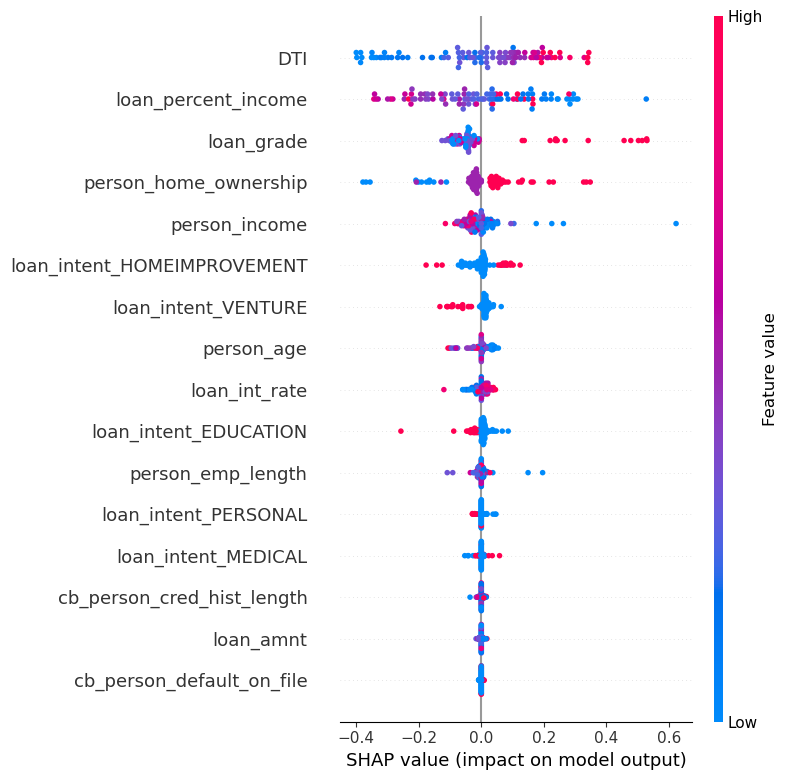

In [16]:
import shap

# Assuming X is your feature matrix and model is your trained model
model = stacking_model

# Define a custom prediction function
def model_predict(data):
    return model.predict(data)

# Use a small sample of the data to initialize the KernelExplainer
background = X.sample(n=100, random_state=42)

# Initialize the SHAP KernelExplainer with the custom prediction function
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values for a sample of the data
sample_data = X.sample(n=100, random_state=42)
shap_values = explainer.shap_values(sample_data)

# Plot the SHAP summary plot
%matplotlib inline
shap.summary_plot(shap_values, sample_data)